# ImageNet-Captions

This notebook creates embeddings for the ImageNet-Captions dataset using the CLIP prototyping experiments.

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

This dataset is created using a subset of ImageNet images that are from the 50 most frequent classes from the original validation set, with captions retrieved from the original Flickr posts. 

In [5]:
NUM_CLASSES = 250
DATA_PATH = f'/mnt/ssd/ronak/datasets/imagenet_captions_{NUM_CLASSES}k'
DEVICE = 'cuda:0'

In [9]:
train_df = pd.read_csv(os.path.join(DATA_PATH, f"imagenet_captions_train_c{NUM_CLASSES}.csv"), header=0, sep="\t")
val_df = pd.read_csv(os.path.join(DATA_PATH, f"imagenet_captions_val_c{NUM_CLASSES}.csv"), header=0, sep="\t")
class_df = pd.read_csv("map_clsloc.txt", sep=" ", header=None)

class_df.columns = ["directory", "class_idx", "class_name"]

In [10]:
train_df

,title,filepath
0,120-2060_IMG,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
1,127-2701_IMG,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
2,Tusker,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
3,Old Tusker,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
4,IMG_0031,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
...,...,...
174589,Royal Albatross (Northern),/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174590,albatross,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174591,mollymawk 3,/mnt/ssd/ronak/datasets/imagenet_captions_250k...
174592,Laysan albatross w/ chick,/mnt/ssd/ronak/datasets/imagenet_captions_250k...


In [11]:
class_df = class_df.set_index("directory")
class_df

,class_idx,class_name
directory,,
n02119789,1,kit_fox
n02100735,2,English_setter
n02110185,3,Siberian_husky
n02096294,4,Australian_terrier
n02102040,5,English_springer
...,...,...
n03063599,996,coffee_mug
n04116512,997,rubber_eraser
n04325704,998,stole


Confirm that the class labels match the folders correctly.

folder n01871265 corresponds to class tusker.


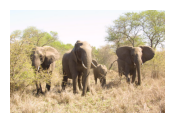

In [12]:
files = list(train_df['filepath'])
folder = os.path.split(files[0])[0].split("/")[-1]
class_name = class_df.loc[folder]['class_name']

print(f"folder {folder} corresponds to class {class_name}.")


img = mpimg.imread(files[0])

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

Our goal is to create data frames that contain the embeddings of the images using different models, embeddings of the captions, embeddings of the class names, and the list of class indices and names in natural language.

In [13]:
def add_class_columns(df):
    df['directory'] = df['filepath'].map(lambda x: os.path.split(x)[0].split("/")[-1])
    df['class_name'] = df['directory'].map(lambda x: class_df.loc[x]['class_name'])
    df['class_idx'] = df['directory'].map(lambda x: class_df.loc[x]['class_idx'])
    return df

train_df = add_class_columns(train_df)
val_df = add_class_columns(val_df)

train_df

,title,filepath,directory,class_name,class_idx
0,120-2060_IMG,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n01871265,tusker,214
1,127-2701_IMG,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n01871265,tusker,214
2,Tusker,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n01871265,tusker,214
3,Old Tusker,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n01871265,tusker,214
4,IMG_0031,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n01871265,tusker,214
...,...,...,...,...,...
174589,Royal Albatross (Northern),/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n02058221,albatross,441
174590,albatross,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n02058221,albatross,441
174591,mollymawk 3,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n02058221,albatross,441
174592,Laysan albatross w/ chick,/mnt/ssd/ronak/datasets/imagenet_captions_250k...,n02058221,albatross,441


## Save Class Labels in Natural Language

In [14]:
train_class_labels = train_df[["class_name", "class_idx"]]
val_class_labels = val_df[["class_name", "class_idx"]]

train_class_labels.to_csv(os.path.join(DATA_PATH, "train_class_labels.txt"), sep="\t", index=False)
val_class_labels.to_csv(os.path.join(DATA_PATH, "val_class_labels.txt"), sep="\t", index=False)

## Create Image and Text Embeddings using CLIP ViT-B/32

Using [ViT-B/32](https://github.com/ronakdm/open_clip_dev/blob/main/docs/PRETRAINED.md) model trained on LAION-2B, which reaches an ImageNet top-1 zero-shot accuracy of 65.62%.

In [15]:
import open_clip
from training.data import get_data, CsvDataset
from training.params import parse_args
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

MODEL_NAME = "vit_b32_laion2b"

In [16]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(DEVICE)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

print("Log scale:", model.logit_scale)
print("Scale:", model.logit_scale.exp())

Log scale: Parameter containing:
tensor(4.6052, device='cuda:0', requires_grad=True)
Scale: tensor(100., device='cuda:0', grad_fn=<ExpBackward0>)


In [17]:
params = [
    "--train-data", f"{DATA_PATH}/imagenet_captions_train_c{NUM_CLASSES}.csv",
    "--val-data", f"{DATA_PATH}/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False

In [23]:
# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvDataset(
    input_filename,
    preprocess_train,
    img_key=args.csv_img_key,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
    tokenizer=tokenizer,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

dataloader = DataLoader(
    dataset,
    batch_size=1024,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False, # TODO: Changed from original
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

Test that dataset order from dataloader agrees with original dataset order.

torch.Size([1024, 3, 224, 224])
torch.Size([1024, 77])


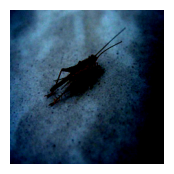

<start_of_text>cricket <end_of_text>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class_name    cricket
class_idx         632
Name: 49270, dtype: object


In [24]:
for i, batch in enumerate(dataloader):
    idx, images, texts = batch
    break

print(images.shape)
print(texts.shape)

batch_id = 0

# show image from dataloader
img = images[batch_id].numpy().transpose([1, 2, 0])
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

# show decoded text from dataloader
txt = texts[batch_id]
print(tokenizer.decode([elem.item() for elem in txt]))

# show caption for dataset
print(train_class_labels.loc[idx[batch_id].item()])


In [25]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy")):
    print("found embeddings - loading...")
    all_image_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"))
    all_text_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    all_image_features, all_text_features, all_idx = [], [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, images, texts = batch
            image_features = model.encode_image(images.to(DEVICE))
            text_features = model.encode_text(texts.to(DEVICE))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
            all_idx.append(idx)
            
    all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
    all_text_features = torch.cat(all_text_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"), all_image_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"), all_text_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_image_features.shape)
print(all_text_features.shape)
print(all_idx.shape)

0it [00:00, ?it/s]

171it [08:57,  3.15s/it]


(174594, 512)
(174594, 512)
(174594,)


## Create Image Embeddings using ConvNeXt



In [32]:
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from torch.utils.data import Dataset, DataLoader
from PIL import Image

MODEL_NAME = "convnext_base"
DEVICE = "cuda:1"

In [33]:
model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1).to(DEVICE)
return_nodes = {
    # node_name: user-specified key for output dict
    'avgpool': 'features',
}
body = create_feature_extractor(model, return_nodes=return_nodes)
transforms = ConvNeXt_Base_Weights.IMAGENET1K_V1.transforms()

In [34]:
class CsvImageDataset(Dataset):
    def __init__(self, input_filename, transforms, img_key, caption_key, sep="\t"):
        df = pd.read_csv(input_filename, sep=sep)

        self.images = df[img_key].tolist()
        self.captions = df[caption_key].tolist()
        self.transforms = transforms

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        images = self.transforms(Image.open(str(self.images[idx])).convert("RGB"))
        return idx, images

In [35]:
# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvImageDataset(
    input_filename,
    transforms,
    img_key=args.csv_img_key,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

dataloader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False, # TODO: Changed from original
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

torch.Size([512, 3, 224, 224])


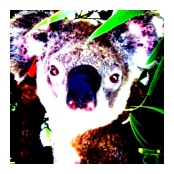

class_name    koala
class_idx       213
Name: 153382, dtype: object


In [36]:
for i, batch in enumerate(dataloader):
    idx, images = batch
    break

print(images.shape)

batch_id = 0

# show image from dataloader
img = images[batch_id].numpy().transpose([1, 2, 0])
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

# show caption for dataset
print(train_class_labels.loc[idx[batch_id].item()])

In [37]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy")):
    print("found embeddings - loading...")
    all_image_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    print("no embeddings found - computing...")
    all_image_features, all_idx = [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, images = batch
            image_features = body(images.to(DEVICE))['features'].squeeze()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features)
            all_idx.append(idx)
            
    all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"), all_image_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_image_features.shape)
print(all_idx.shape)

no embeddings found - computing...


342it [24:22,  4.28s/it]


(174594, 1024)
(174594,)


## Create Text Embeddings using GloVe

In [38]:
# load class dictionary
embeddings_dict = {}
fpath = "/mnt/ssd/ronak/datasets/glove/glove.6B.50d.txt"
with open(fpath, 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

0it [00:00, ?it/s]

400000it [00:08, 45415.47it/s] 


In [39]:
# check how many of them are in the GloVe dictionary.

classes = list(class_df['class_name'])
observed = []
for c in classes:
    if c in embeddings_dict:
        observed.append(c)
print(f"{len(observed)}/{len(classes)} class names observed in GloVe vocabulary")

539/1000 class names observed in GloVe vocabulary


In [40]:
# find classes observed in the dataset
observed = np.array(observed)

np.random.seed(123)
k = len(observed)
test_size = int(0.1 * k)
train_class_idx = np.random.choice(k, size=(k - test_size), replace=False)
val_class_idx = np.delete(np.arange(k), train_class_idx)

train_class_names = [observed[i] for i in train_class_idx]
val_class_names = [observed[i] for i in val_class_idx]

print(train_class_names)
print(val_class_names)

print(len(train_class_names))
print(len(val_class_names))

['scale', 'dumbbell', 'muzzle', 'ringlet', 'maraca', 'trolleybus', 'kimono', 'daisy', 'conch', 'buckle', 'notebook', 'file', 'orange', 'meerkat', 'joystick', 'diaper', 'holster', 'sorrel', 'badger', 'monitor', 'mosque', 'washer', 'thresher', 'guacamole', 'sunglasses', 'otter', 'stupa', 'altar', 'cradle', 'gibbon', 'peacock', 'albatross', 'organ', 'revolver', 'goldfinch', 'bloodhound', 'hippopotamus', 'crane', 'baboon', 'buckeye', 'hamster', 'dough', 'doormat', 'cairn', 'lotion', 'vizsla', 'geyser', 'birdhouse', 'papillon', 'pedestal', 'trilobite', 'candle', 'quill', 'crib', 'loupe', 'modem', 'chimpanzee', 'sweatshirt', 'tarantula', 'dishrag', 'pot', 'iron', 'menu', 'matchstick', 'balloon', 'drake', 'dome', 'grasshopper', 'accordion', 'tabby', 'barrel', 'vulture', 'carousel', 'reel', 'cello', 'gong', 'langur', 'suit', 'packet', 'liner', 'caldron', 'cup', 'binoculars', 'brass', 'bonnet', 'envelope', 'briard', 'cornet', 'loggerhead', 'guenon', 'sundial', 'lampshade', 'mortar', 'cliff', 'w

In [41]:
# find the data indices associated to these classes
n = len(train_df)

train_idx = np.arange(n)[np.array(train_df['class_name'].map(lambda x: x in train_class_names))]
val_idx = np.arange(n)[np.array(train_df['class_name'].map(lambda x: x in val_class_names))]

print(len(train_idx))
print(len(val_idx))

assert len(np.intersect1d(train_idx, val_idx)) == 0

np.save(os.path.join(DATA_PATH, f"glove_train_idx.npy"), train_idx)
np.save(os.path.join(DATA_PATH, f"glove_val_idx.npy"), val_idx)

156725
17869


In [42]:
train_labels = list(train_df.iloc[train_idx]['class_name'])
val_labels = list(train_df.iloc[val_idx]['class_name'])

train_embeds = np.array([embeddings_dict[label] for label in train_labels])
val_embeds = np.array([embeddings_dict[label] for label in val_labels])

print(train_embeds.shape)
print(val_embeds.shape)

np.save(os.path.join(DATA_PATH, f"glove_train_embeds.npy"), train_embeds)
np.save(os.path.join(DATA_PATH, f"glove_val_embeds.npy"), val_embeds)

(156725, 50)
(17869, 50)


In [43]:
# create validation class labels.
observed_val_class_names = np.unique(val_labels)
val_label_to_class_id = {observed_val_class_names[i]: i for i in range(len(observed_val_class_names))}
val_class_id = np.array([val_label_to_class_id[name] for name in val_labels])
val_class_embeds = np.array([embeddings_dict[label] for label in observed_val_class_names])

print(val_class_id.shape)
print(val_class_embeds.shape)

np.save(os.path.join(DATA_PATH, f"glove_val_class_id_labels.npy"), val_class_id)
np.save(os.path.join(DATA_PATH, f"glove_val_class_embeds.npy"), val_class_embeds)

(17869,)
(24, 50)
